In [1]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [2]:
batch_size = 64

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
])

train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=train_transform
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=test_transform
)

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=8)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=8)

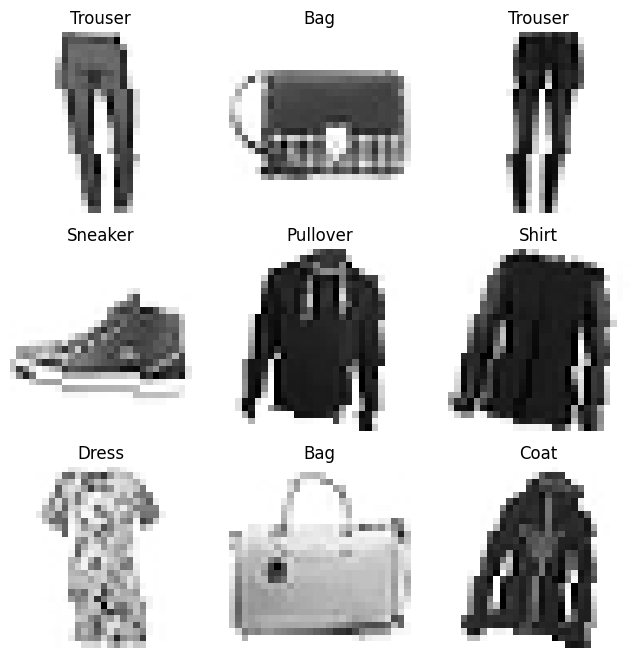

In [3]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="Grays")
plt.show()

In [4]:
class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_stack = nn.Sequential(
            nn.Conv2d(1, 6, 5),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(6, 16, 5),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(16*4*4, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, 10),
            nn.Softmax(1)
        )

    def forward(self, x):
        logits = self.conv_stack(x)
        return logits

In [17]:
class VGG(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_stack = nn.Sequential(
            nn.Conv2d(1, 4, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(4, 4, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(4, 8, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(8, 8, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(8*7*7, 8*7*7),
            nn.ReLU(),
            nn.Linear(8*7*7, 8*7*7),
            nn.ReLU(),
            nn.Linear(8*7*7, 10),
            nn.Softmax(1)
        )

    def forward(self, x):
        logits = self.conv_stack(x)
        return logits

In [6]:
class NetworkTrainer:
    def __init__(self, model: nn.Module, 
                 loss_fn: nn.modules.loss._Loss, 
                 optimiser: optim.Optimizer) -> None:
        self.model = model
        self.loss_fn = loss_fn
        self.optimiser = optimiser

    def train_model(self, epochs):
        train_loss_list = []
        train_acc_list = []
        test_loss_list = []
        test_acc_list = []
        for epoch in range(epochs):
            print(f'EPOCH {epoch+1}')
            train_loss, train_acc = self._train_epoch()
            test_loss, test_acc = self._eval_epoch()
            train_loss_list.append(train_loss)
            train_acc_list.append(train_acc)
            test_loss_list.append(test_loss)
            test_acc_list.append(test_acc)
            print(f'Loss: {train_loss:.3f}, Val_Loss: {test_loss:.3f}')
            print(f'Accuracy: {train_acc:.2f}, Val_Accuracy: {test_acc:.2f}\n')
        return train_loss_list, train_acc_list, test_loss_list, test_acc_list

    def _train_epoch(self):
        self.model.train(True)
        running_loss = 0.0
        correct = 0
        for i, data in enumerate(train_dataloader):
            inputs: torch.Tensor = data[0]
            labels = data[1]
            self.optimiser.zero_grad()
            outputs = self.model(inputs)
            loss: torch.Tensor = self.loss_fn(outputs, labels)
            loss.backward()
            self.optimiser.step()
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels)
        avg_loss = running_loss / len(train_data)
        accuracy = 100 * correct / len(train_data)
        return avg_loss, accuracy

    def _eval_epoch(self):
        self.model.eval()
        running_loss = 0.0
        correct = 0
        with torch.no_grad():
            for i, data in enumerate(test_dataloader):
                inputs: torch.Tensor = data[0]
                labels = data[1]
                outputs = self.model(inputs)
                loss = self.loss_fn(outputs, labels)
                running_loss += loss * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                correct += torch.sum(preds == labels)
        avg_loss = running_loss / len(test_data)
        accuracy = 100 * correct / len(test_data)
        return avg_loss, accuracy

In [7]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [8]:
lenet_model = LeNet().to(device)
loss_fn = nn.CrossEntropyLoss()
lenet_optimiser = optim.Adam(lenet_model.parameters(), lr=0.001)

In [9]:
print(lenet_model)

LeNet(
  (conv_stack): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): ReLU()
    (4): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Flatten(start_dim=1, end_dim=-1)
    (8): Linear(in_features=256, out_features=120, bias=True)
    (9): ReLU()
    (10): Linear(in_features=120, out_features=84, bias=True)
    (11): ReLU()
    (12): Linear(in_features=84, out_features=10, bias=True)
    (13): Softmax(dim=1)
  )
)


In [10]:
lenet_trainer = NetworkTrainer(lenet_model, loss_fn, lenet_optimiser)
lenet_results = lenet_trainer.train_model(25)

EPOCH 1
Loss: 1.757, Val_Loss: 1.699
Accuracy: 70.84, Val_Accuracy: 76.31

EPOCH 2
Loss: 1.670, Val_Loss: 1.654
Accuracy: 79.17, Val_Accuracy: 80.75

EPOCH 3
Loss: 1.643, Val_Loss: 1.641
Accuracy: 81.83, Val_Accuracy: 82.02

EPOCH 4
Loss: 1.631, Val_Loss: 1.634
Accuracy: 82.99, Val_Accuracy: 82.77

EPOCH 5
Loss: 1.621, Val_Loss: 1.617
Accuracy: 84.04, Val_Accuracy: 84.46

EPOCH 6
Loss: 1.615, Val_Loss: 1.629
Accuracy: 84.57, Val_Accuracy: 83.14

EPOCH 7
Loss: 1.611, Val_Loss: 1.614
Accuracy: 84.97, Val_Accuracy: 84.70

EPOCH 8
Loss: 1.605, Val_Loss: 1.615
Accuracy: 85.52, Val_Accuracy: 84.67

EPOCH 9
Loss: 1.601, Val_Loss: 1.602
Accuracy: 86.03, Val_Accuracy: 85.90

EPOCH 10
Loss: 1.597, Val_Loss: 1.594
Accuracy: 86.42, Val_Accuracy: 86.64

EPOCH 11
Loss: 1.596, Val_Loss: 1.604
Accuracy: 86.47, Val_Accuracy: 85.73

EPOCH 12
Loss: 1.594, Val_Loss: 1.597
Accuracy: 86.69, Val_Accuracy: 86.52

EPOCH 13
Loss: 1.592, Val_Loss: 1.592
Accuracy: 86.85, Val_Accuracy: 86.85

EPOCH 14
Loss: 1.590,

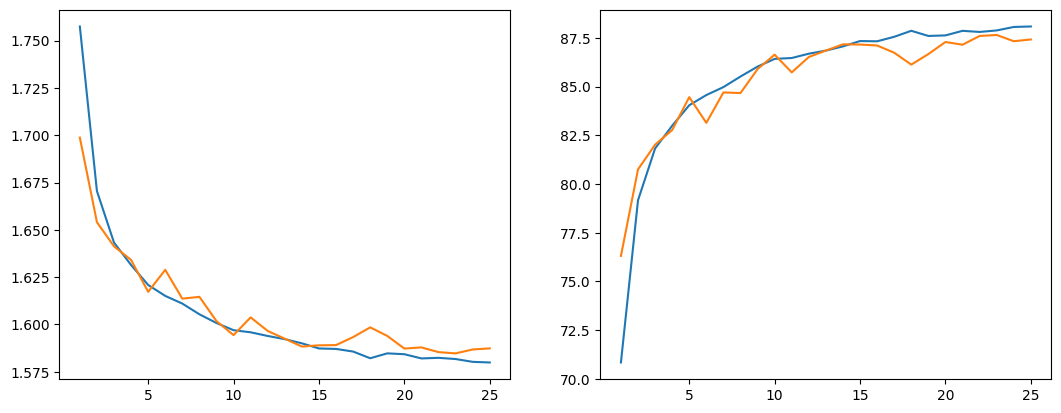

In [12]:
train_loss_list, train_acc_list, test_loss_list, test_acc_list = lenet_results

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12.8, 4.8))
ax1.plot(range(1,26), train_loss_list)
ax1.plot(range(1,26), test_loss_list)
ax1.set_xticks(range(5,26,5))
ax2.plot(range(1,26), train_acc_list)
ax2.plot(range(1,26), test_acc_list)
ax2.set_xticks(range(5,26,5))
plt.show()

In [18]:
vgg_model = VGG().to(device)
loss_fn = nn.CrossEntropyLoss()
vgg_optimiser = optim.Adam(vgg_model.parameters(), lr=0.001)

In [19]:
print(vgg_model)

VGG(
  (conv_stack): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU()
    (6): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): ReLU()
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): Linear(in_features=392, out_features=392, bias=True)
    (14): ReLU()
    (15): Linear(in_features=392, out_features=392, bias=True)
    (16): ReLU()
    (17): Linear(in_features=392, out_features=10, bias=True)
    (18): Softmax(dim=1)
  )
)


In [20]:
vgg_trainer = NetworkTrainer(vgg_model, loss_fn, vgg_optimiser)
vgg_results = vgg_trainer.train_model(25)

EPOCH 1
Loss: 1.764, Val_Loss: 1.695
Accuracy: 69.72, Val_Accuracy: 76.62

EPOCH 2
Loss: 1.668, Val_Loss: 1.674
Accuracy: 79.34, Val_Accuracy: 78.61

EPOCH 3
Loss: 1.647, Val_Loss: 1.647
Accuracy: 81.40, Val_Accuracy: 81.29

EPOCH 4
Loss: 1.635, Val_Loss: 1.631
Accuracy: 82.58, Val_Accuracy: 82.99

EPOCH 5
Loss: 1.626, Val_Loss: 1.622
Accuracy: 83.44, Val_Accuracy: 83.85

EPOCH 6
Loss: 1.619, Val_Loss: 1.619
Accuracy: 84.20, Val_Accuracy: 84.26

EPOCH 7
Loss: 1.616, Val_Loss: 1.608
Accuracy: 84.43, Val_Accuracy: 85.34

EPOCH 8
Loss: 1.611, Val_Loss: 1.613
Accuracy: 84.97, Val_Accuracy: 84.73

EPOCH 9
Loss: 1.608, Val_Loss: 1.609
Accuracy: 85.27, Val_Accuracy: 85.13

EPOCH 10
Loss: 1.605, Val_Loss: 1.603
Accuracy: 85.60, Val_Accuracy: 85.77

EPOCH 11
Loss: 1.601, Val_Loss: 1.602
Accuracy: 85.98, Val_Accuracy: 85.80

EPOCH 12
Loss: 1.605, Val_Loss: 1.614
Accuracy: 85.58, Val_Accuracy: 84.69

EPOCH 13
Loss: 1.602, Val_Loss: 1.600
Accuracy: 85.84, Val_Accuracy: 86.11

EPOCH 14
Loss: 1.597,

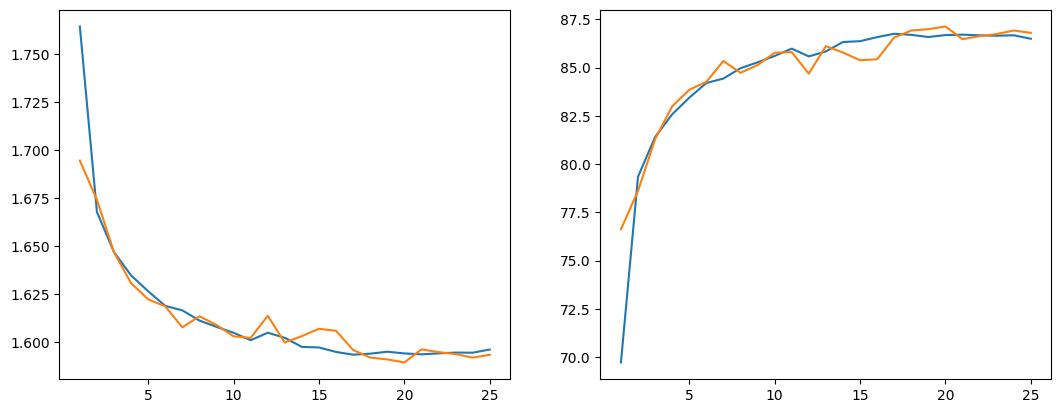

In [22]:
train_loss_list, train_acc_list, test_loss_list, test_acc_list = vgg_results

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12.8, 4.8))
ax1.plot(range(1,26), train_loss_list)
ax1.plot(range(1,26), test_loss_list)
ax1.set_xticks(range(5,26,5))
ax2.plot(range(1,26), train_acc_list)
ax2.plot(range(1,26), test_acc_list)
ax2.set_xticks(range(5,26,5))
plt.show()